In [1]:
import sys
import os
import cpa
import scanpy as sc



[rank: 0] Global seed set to 0


In [41]:
data_path = 'data/kang_normalized_hvg.h5ad'
adata = sc.read(data_path)

In [42]:
adata.X = adata.layers['counts'].copy()

In [43]:
# We will create a dummy dosage variable for each condition (control, IFN-beta stimulated). 
# It is recommended to use Identity (i.e. doser_type = 'identity') for dosage scaling function when there is no dosage information available.

adata.obs['dose'] = adata.obs['condition'].apply(lambda x: '+'.join(['1.0' for _ in x.split('+')]))
adata.obs['cell_type'].value_counts()


CD14 Mono    4362
CD4 T        4266
B            1366
CD16 Mono    1044
CD8 T         814
T             633
NK            619
DC            472
Name: cell_type, dtype: int64

In [44]:
adata.obs['condition'].value_counts()

stimulated    7217
ctrl          6359
Name: condition, dtype: int64

In [45]:
cpa.CPA.setup_anndata(adata, 
                      perturbation_key='condition',
                      control_group='ctrl',
                      dosage_key='dose',
                      categorical_covariate_keys=['cell_type'],
                      is_count_data=True,
                      deg_uns_key='rank_genes_groups_cov',
                      deg_uns_cat_key='cov_cond',
                      max_comb_len=1,
                     )

100%|██████████| 16/16 [00:00<00:00, 1713.32it/s]


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [9]:
model_params = {
    "n_latent": 64,
    "recon_loss": "nb",
    "doser_type": "linear",
    "n_hidden_encoder": 128,
    "n_layers_encoder": 2,
    "n_hidden_decoder": 512,
    "n_layers_decoder": 2,
    "use_batch_norm_encoder": True,
    "use_layer_norm_encoder": False,
    "use_batch_norm_decoder": False,
    "use_layer_norm_decoder": True,
    "dropout_rate_encoder": 0.0,
    "dropout_rate_decoder": 0.1,
    "variational": False,
    "seed": 6977,
}

trainer_params = {
    "n_epochs_kl_warmup": None,
    "n_epochs_pretrain_ae": 30,
    "n_epochs_adv_warmup": 50,
    "n_epochs_mixup_warmup": 0,
    "mixup_alpha": 0.0,
    "adv_steps": None,
    "n_hidden_adv": 64,
    "n_layers_adv": 3,
    "use_batch_norm_adv": True,
    "use_layer_norm_adv": False,
    "dropout_rate_adv": 0.3,
    "reg_adv": 20.0,
    "pen_adv": 5.0,
    "lr": 0.0003,
    "wd": 4e-07,
    "adv_lr": 0.0003,
    "adv_wd": 4e-07,
    "adv_loss": "cce",
    "doser_lr": 0.0003,
    "doser_wd": 4e-07,
    "do_clip_grad": True,
    "gradient_clip_value": 1.0,
    "step_size_lr": 10,
}

In [10]:
model = cpa.CPA(adata=adata, 
                split_key='split_B',
                train_split='train',
                valid_split='valid',
                test_split='ood',
                **model_params,
               )

[rank: 0] Global seed set to 6977


In [13]:
model.train(max_epochs=2000,
            use_gpu=True, 
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping_patience=100,
            check_val_every_n_epoch=100,
            save_path='models/',
           )

100%|██████████| 2/2 [00:00<00:00, 85.62it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 100/2000:   5%|▍         | 99/2000 [02:39<51:33,  1.63s/it, v_num=1, recon=562, r2_mean=0.95, adv_loss=2.33, acc_pert=0.538, acc_cell_type=0.394]


Epoch 00099: cpa_metric reached. Module best state updated.



disnt_basal = 0.641279432354036
disnt_after = 1.5464496990166978
val_r2_mean = 0.8923050761222839
val_r2_var = 0.5319457782639397
Epoch 200/2000:  10%|▉         | 199/2000 [05:26<50:04,  1.67s/it, v_num=1, recon=542, r2_mean=0.953, adv_loss=2.33, acc_pert=0.543, acc_cell_type=0.39, val_recon=825, disnt_basal=0.641, disnt_after=1.55, val_r2_mean=0.892, val_KL=nan] 


Epoch 00199: cpa_metric reached. Module best state updated.



disnt_basal = 0.6317564121580922
disnt_after = 1.5429612363801855
val_r2_mean = 0.8781815648078918
val_r2_var = 0.5219597485330371
Epoch 300/2000:  15%|█▍        | 299/2000 [08:13<47:14,  1.67s/it, v_num=1, recon=528, r2_mean=0.956, adv_loss=2.31, acc_pert=0.555, acc_cell_type=0.388, val_recon=857, disnt_basal=0.632, disnt_after=1.54, val_r2_mean=0.878, val_KL=nan]
disnt_basal = 0.6329769543005558
disnt_after = 1.5399538025396746
val_r2_mean = 0.8855832351578607
val_r2_var = 0.5163716249995761
Epoch 400/2000:  20%|█▉        | 399/2000 [11:01<44:04,  1.65s/it, v_num=1, recon=520, r2_mean=0.957, adv_loss=2.31, acc_pert=0.558, acc_cell_type=0.386, val_recon=884, disnt_basal=0.633, disnt_after=1.54, val_r2_mean=0.886, val_KL=nan]
disnt_basal = 0.6384169280914306
disnt_after = 1.5487815883370504
val_r2_mean = 0.8685165378782486
val_r2_var = 0.4999660187297397
Epoch 500/2000:  25%|██▍       | 499/2000 [13:47<41:25,  1.66s/it, v_num=1, recon=512, r2_mean=0.958, adv_loss=2.3, acc_pert=0.555, 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 2000/2000: 100%|██████████| 2000/2000 [55:32<00:00,  1.67s/it, v_num=1, recon=484, r2_mean=0.964, adv_loss=2.29, acc_pert=0.573, acc_cell_type=0.386, val_recon=1.06e+3, disnt_basal=0.634, disnt_after=1.54, val_r2_mean=0.885, val_KL=nan]


In [14]:
latent_outputs = model.get_latent_representation(adata, batch_size=2048)
latent_outputs.keys()

100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

In [15]:
sc.pp.neighbors(latent_outputs['latent_basal'])
sc.tl.umap(latent_outputs['latent_basal'])

         Falling back to preprocessing with `sc.pp.pca` and default params.


2024-07-22 13:47:18.953930: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/ai.mila.quebec/apps/arch/distro/OpenSSL/1.1/lib:/cvmfs/ai.mila.quebec/apps/arch/distro/libreadline/7.0/lib:/cvmfs/ai.mila.quebec/apps/arch/distro/libffi/3.2.1/lib
2024-07-22 13:47:18.955383: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/ai.mila.quebec/apps/arch/distro/OpenSSL/1.1/lib:/cvmfs/ai.mila.quebec/apps/arch/distro/libreadline/7.0/lib:/cvmfs/ai.mila.quebec/apps/arch/distro/libffi/3.2.1/lib
2024-07-22 13:47:18.955392: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libr

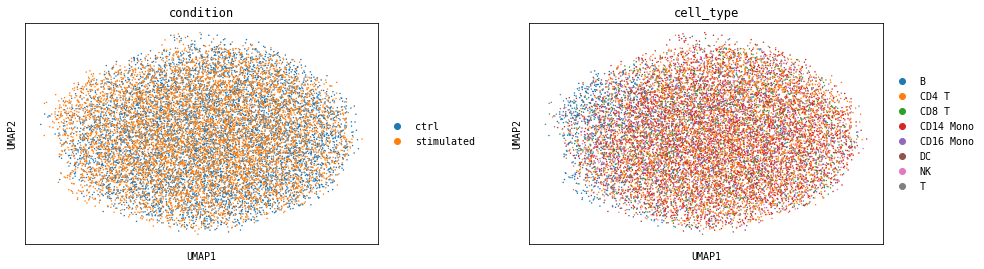

In [31]:

sc.pl.umap(latent_outputs['latent_basal'], 
           color=['condition', 'cell_type'],
           frameon=True, 
           wspace=0.3,
)


In [32]:
sc.pp.neighbors(latent_outputs['latent_after'])
sc.tl.umap(latent_outputs['latent_after'])

         Falling back to preprocessing with `sc.pp.pca` and default params.


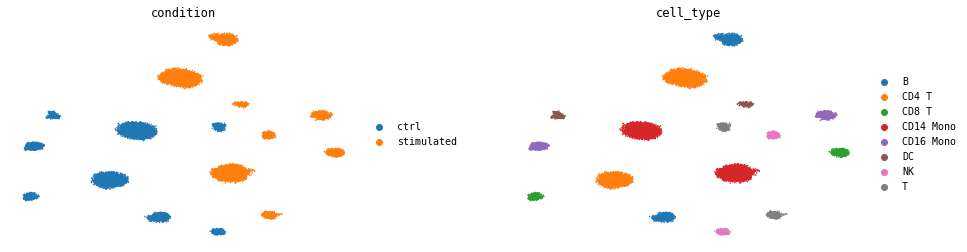

In [39]:
sc.pl.umap(latent_outputs['latent_after'], 
           color=['condition', 'cell_type'], 
           frameon=False,
           wspace=0.3)

In [46]:
model.predict(adata, batch_size=2048)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


In [47]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from collections import defaultdict
from tqdm import tqdm

n_top_degs = [10, 20, 50, None] # None means all genes

results = defaultdict(list)
for cat in tqdm(adata.obs['cov_cond'].unique()):
    if 'ctrl' not in cat:
        cov, condition = cat.split('_')
        cat_adata = adata[adata.obs['cov_cond'] == cat].copy()
        ctrl_adata = adata[adata.obs['cov_cond'] == f'{cov}_ctrl'].copy()

        deg_cat = f'{cat}'
        deg_list = adata.uns['rank_genes_groups_cov'][deg_cat]
        
        x_true = cat_adata.layers['counts']
        x_pred = cat_adata.obsm['CPA_pred']
        x_ctrl = ctrl_adata.layers['counts']

        x_true = np.log1p(x_true)
        x_pred = np.log1p(x_pred)
        x_ctrl = np.log1p(x_ctrl)

        for n_top_deg in n_top_degs:
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'
                
            x_true_deg = x_true[:, degs]
            x_pred_deg = x_pred[:, degs]
            x_ctrl_deg = x_ctrl[:, degs]
            
            r2_mean_deg = r2_score(x_true_deg.mean(0), x_pred_deg.mean(0))
            r2_var_deg = r2_score(x_true_deg.var(0), x_pred_deg.var(0))

            r2_mean_lfc_deg = r2_score(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))
            r2_var_lfc_deg = r2_score(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))
            
            results['condition'].append(condition)
            results['cell_type'].append(cov)
            results['n_top_deg'].append(n_top_deg)
            results['r2_mean_deg'].append(r2_mean_deg)
            results['r2_var_deg'].append(r2_var_deg)
            results['r2_mean_lfc_deg'].append(r2_mean_lfc_deg)
            results['r2_var_lfc_deg'].append(r2_var_lfc_deg)

df = pd.DataFrame(results)

100%|██████████| 16/16 [00:01<00:00,  8.51it/s]


In [48]:
df

,condition,cell_type,n_top_deg,r2_mean_deg,r2_var_deg,r2_mean_lfc_deg,r2_var_lfc_deg
0,stimulated,CD8 T,10,0.956492,-5.623676,0.935747,-3.802478
1,stimulated,CD8 T,20,0.962800,-3.365848,0.947253,-2.706663
2,stimulated,CD8 T,50,0.956367,-0.068169,0.938801,-1.580142
3,stimulated,CD8 T,all,0.970873,0.698663,0.906313,-0.535264
4,stimulated,CD4 T,10,0.960287,-41.055606,0.945085,-1.915499
5,stimulated,CD4 T,20,0.955444,-5.910073,0.937226,-1.930013
6,stimulated,CD4 T,50,0.958486,0.046602,0.945555,-1.238344
7,stimulated,CD4 T,all,0.970489,0.619868,0.914661,-0.803435
8,stimulated,B,10,0.768052,-0.219163,0.621841,0.077252
9,stimulated,B,20,0.812331,-0.540178,0.750871,-0.199870
